In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import os
import argparse

from models import VGG16Head, VGG16Tail, ResNet18Head, ResNet18Tail
import config
from watermark import Watermark

/ssddata/whuak/anaconda3/envs/fyp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_dir = '/ssddata/whuak/fyp_adv_collusion_tracing/adv_tracing/saved_models/ResNet18-CIFAR10'

In [3]:
head_ind = 0

In [4]:
head_dir = model_dir + f"/head_{head_ind}/state_dict"
tail_dir = model_dir + "/base_tail_state_dict"
wm_dir = model_dir + f'/head_{head_ind}/watermark.npy'

In [5]:
head_dir

'/ssddata/whuak/fyp_adv_collusion_tracing/adv_tracing/saved_models/ResNet18-CIFAR10/head_0/state_dict'

In [78]:

C, H, W = 3, 32, 32

# Create the model and the dataset
dataset = eval(f'config.CIFAR10()')
training_set, testing_set = dataset.training_set, dataset.testing_set
num_classes = dataset.num_classes
means, stds = dataset.means, dataset.stds
Head, Tail = eval(f'ResNet18Head'), eval(f'ResNet18Tail')
normalizer = transforms.Normalize(means, stds)
# training_loader = torch.utils.data.DataLoader(training_set, batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
# testing_loader = torch.utils.data.DataLoader(testing_set, batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Place to save the trained model
# save_dir = f'saved_models/{args.model_name}-{args.dataset_name}'
# os.makedirs(save_dir, exist_ok = True)

# Load the tail of the model
tail = Tail(num_classes)
tail.load_state_dict(torch.load(tail_dir))

head = Head()
head.load_state_dict(torch.load(head_dir))

wm = Watermark.load(wm_dir)

model = nn.Sequential(normalizer, wm, head, tail).eval()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Bandit, NES, HopSkipJump, SignOPT, SimBA-px
import numpy as np
a = np.load(f"/ssddata/whuak/fyp_adv_collusion_tracing/adv_tracing/saved_adv_examples/ResNet18-CIFAR10/head_{head_ind}/NES.npz", allow_pickle=True)
a

NpzFile '/ssddata/whuak/fyp_adv_collusion_tracing/adv_tracing/saved_adv_examples/ResNet18-CIFAR10/head_0/NES.npz' with keys: X, X_attacked, y

In [9]:
img = torch.from_numpy(a['X'])
img_adv = torch.from_numpy(a['X_attacked'])
label = torch.from_numpy(a['y'])

In [10]:
img.shape

torch.Size([14, 3, 32, 32])

In [58]:
y_pred = model(img).argmax(dim=1)
y_pred_adv = model(img_adv).argmax(dim=1)
y_pred, label, y_pred_adv

(tensor([4, 0, 7, 9, 3, 6, 3, 6, 4, 3, 7, 0, 3, 8]),
 tensor([4, 0, 7, 9, 3, 6, 3, 6, 4, 3, 7, 0, 3, 8]),
 tensor([3, 8, 2, 8, 6, 5, 5, 2, 2, 4, 5, 4, 5, 9]))

In [59]:
label == y_pred, label == y_pred_adv

(tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False]))

In [60]:
adv_perturb = img_adv - img
adv_collusion = adv_perturb[4] + adv_perturb[5]
img_adv_collusion = img + adv_collusion 
img_adv_collusion = img_adv_collusion.view(-1, 3, 32, 32)

y_pred_collusion = model(img_adv_collusion).argmax(dim=1)
y_pred_collusion, y_pred_collusion == label

(tensor([4, 0, 7, 9, 3, 6, 3, 6, 4, 3, 7, 0, 3, 8]),
 tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]))

In [17]:
size = len(label)
torch.zeros(size, size)
success_sample_2 = 0
success_sample_list_2 = []
for i in range(len(label)):
    for j in range(len(label)):
        adv_perturb = img_adv - img
        adv_collusion = adv_perturb[i] + adv_perturb[j]
        img_adv_collusion = img + adv_collusion 
        img_adv_collusion = img_adv_collusion.view(-1, 3, 32, 32)

        y_pred_collusion = model(img_adv_collusion).argmax(dim=1)

        # if y_pred_collusion[i] == y_pred_collusion[j] and y_pred_collusion[i]  != label[i] and  y_pred_collusion[j]  != label[j]:
        if y_pred_collusion[i]  != label[i] or y_pred_collusion[j]  != label[j]:
            success_sample_2 += 1
            success_sample_list_2.append((i,j))

       

success_sample_2 / size**2

0.6020408163265306

In [ ]:
success_transfer = 0
adv_perturb = img_adv - img
for i in range(len(label)):
    print(i)
    transfer_attack = img + adv_perturb[i:i+1]
    y_pred_transfer = model(transfer_attack).argmax(dim=1)
    success_transfer += ((y_pred_transfer != label).sum() - 1)
    print(y_pred_transfer != label)
success_transfer / (size*(size - 1))

In [24]:
success_sample_3 = 0
success_sample_list_3 = []
for i in range(len(label)):
    for j in range(len(label)):
        for k in range(len(label)):

            adv_perturb = img_adv - img
            adv_collusion = adv_perturb[i] + adv_perturb[j] + adv_perturb[j]
            img_adv_collusion = img + adv_collusion 
            img_adv_collusion = img_adv_collusion.view(-1, 3, 32, 32)

            y_pred_collusion = model(img_adv_collusion).argmax(dim=1)

            # if y_pred_collusion[i] == y_pred_collusion[j]==y_pred_collusion[k] \
            #     and y_pred_collusion[i]  != label[i] and  y_pred_collusion[j]  != label[j] \
            #     and y_pred_collusion[k]  != label[k]: # attack success rate = 0.01
            if  y_pred_collusion[i]  != label[i] or  y_pred_collusion[j]  != label[j] \
                or y_pred_collusion[k]  != label[k]:

                success_sample_3 += 1
                success_sample_list_3.append((i,j,k))

success_sample_3 / size**3

1.0

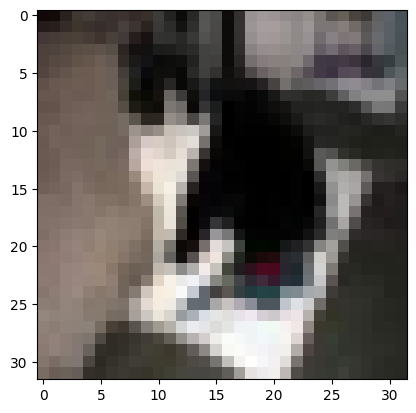

In [20]:
from matplotlib import pyplot as plt
plt.imshow(img[0].permute((1, 2, 0)))
plt.show()

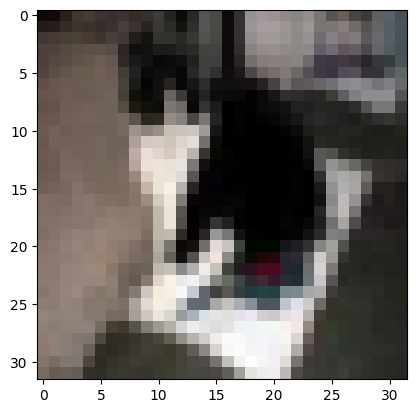

In [21]:
from matplotlib import pyplot as plt
plt.imshow(img_adv[0].permute((1, 2, 0)))
plt.show()

In [71]:
a = np.load(f"/ssddata/whuak/fyp_adv_collusion_tracing/adv_tracing/saved_adv_examples/ResNet18-CIFAR10/head_1/NES.npz", allow_pickle=True)

img = torch.from_numpy(a['X'])
img_adv = torch.from_numpy(a['X_attacked'])
label = torch.from_numpy(a['y'])



In [72]:
label

tensor([4, 1, 0, 8, 0, 3, 7, 6, 3, 6])

In [73]:
from tqdm import tqdm

In [ ]:
def load_model(model_dir, head_index):
    head_dir = model_dir + f"/head_{head_index}/state_dict"
    tail_dir = model_dir + "/base_tail_state_dict"
    wm_dir = model_dir + f'/head_{head_index}/watermark.npy'
    C, H, W = 3, 32, 32

    # Create the model and the dataset
    dataset = eval(f'config.CIFAR10()')
    training_set, testing_set = dataset.training_set, dataset.testing_set
    num_classes = dataset.num_classes
    means, stds = dataset.means, dataset.stds
    Head, Tail = eval(f'ResNet18Head'), eval(f'ResNet18Tail')
    normalizer = transforms.Normalize(means, stds)
    # training_loader = torch.utils.data.DataLoader(training_set, batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
    # testing_loader = torch.utils.data.DataLoader(testing_set, batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Place to save the trained model
    # save_dir = f'saved_models/{args.model_name}-{args.dataset_name}'
    # os.makedirs(save_dir, exist_ok = True)

    # Load the tail of the model
    tail = Tail(num_classes)
    tail.load_state_dict(torch.load(tail_dir))

    head = Head()
    head.load_state_dict(torch.load(head_dir))

    wm = Watermark.load(wm_dir)

    model = nn.Sequential(normalizer, wm, head, tail).eval()

    return model

In [ ]:

total = 0
success_num = 0

for i in tqdm(range(100)):
    

    

    head_dir = model_dir + f"/head_{i}/state_dict"
    tail_dir = model_dir + "/base_tail_state_dict"
    wm_dir = model_dir + f'/head_{i}/watermark.npy'


    
    C, H, W = 3, 32, 32

    # Create the model and the dataset
    dataset = eval(f'config.CIFAR10()')
    training_set, testing_set = dataset.training_set, dataset.testing_set
    num_classes = dataset.num_classes
    means, stds = dataset.means, dataset.stds
    Head, Tail = eval(f'ResNet18Head'), eval(f'ResNet18Tail')
    normalizer = transforms.Normalize(means, stds)
    # training_loader = torch.utils.data.DataLoader(training_set, batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
    # testing_loader = torch.utils.data.DataLoader(testing_set, batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Place to save the trained model
    # save_dir = f'saved_models/{args.model_name}-{args.dataset_name}'
    # os.makedirs(save_dir, exist_ok = True)

    # Load the tail of the model
    tail = Tail(num_classes)
    tail.load_state_dict(torch.load(tail_dir))

    head = Head()
    head.load_state_dict(torch.load(head_dir))

    wm = Watermark.load(wm_dir)

    model = nn.Sequential(normalizer, wm, head, tail).eval()

    for j in range(100):
        if i == j:
            continue

        a = np.load(f"/ssddata/whuak/fyp_adv_collusion_tracing/adv_tracing/saved_adv_examples/ResNet18-CIFAR10/head_{j}/NES.npz", allow_pickle=True)

        img = torch.from_numpy(a['X'])
        img_adv = torch.from_numpy(a['X_attacked'])
        label = torch.from_numpy(a['y'])
        
    
        # y_pred = model(img).argmax(dim=1)
        y_pred_adv = model(img_adv).argmax(dim=1)

        success_num += (y_pred_adv != label).sum().item()
        total += len(label)

    

success_num / total

    

In [70]:
0.19696969696969696

0.19696969696969696

In [ ]:
# k = 2
# for i in range(100):
#     np.random.choice(range(100), k)
#     for k_ind in range(k):
#         model = load_model(model_dir, k_ind)
#         model


In [1]:
import numpy as np
np.random.choice(np.arange(100), 2)

array([21, 89])

In [7]:
np.load('saved_collusion_adv_examples/ResNet18-CIFAR10/NES.npz', allow_pickle=True)

NpzFile 'saved_collusion_adv_examples/ResNet18-CIFAR10/NES.npz' with keys: X, X_attacked, y, head

In [22]:
x = np.zeros((10,3,32,32))

In [23]:
np.stack([x,x]).shape

(2, 10, 3, 32, 32)

In [30]:
np.random.choice([True, False], size=(2,3,3), p=[0.1, 0.9]).shape

(2, 3, 3)

In [1]:
import numpy as np

In [3]:
a = np.zeros((2, 1, 3, 32, 32))
b = np.zeros((2, 5, 3, 32, 32))
np.concatenate([a,b], axis=1).shape

(2, 6, 3, 32, 32)

In [5]:
a = np.load('/ssddata/whuak/fyp_adv_collusion_tracing/adv_tracing/saved_collusion_adv_examples/ResNet18-CIFAR10/2_attackers/HopSkipJump_100_num_of_samples.npz', allow_pickle=True)


In [8]:
a['X_attacked_k'].shape

(2, 102, 3, 32, 32)

In [9]:
np.array([0,1])

array([0, 1])

In [10]:
b = 2

In [34]:
b in np.array([0,1])

False

In [2]:
import torch
import torch.nn as nn
import os
import argparse

from torchvision import transforms
from models import VGG16Head, VGG16Tail, ResNet18Head, ResNet18Tail
import config


/ssddata/whuak/anaconda3/envs/fyp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
dataset = config.GTSRB()
training_set, testing_set = dataset.training_set, dataset.testing_set
num_classes = dataset.num_classes

100%|██████████| 187490228/187490228 [01:40<00:00, 1856949.41it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 88978620/88978620 [00:54<00:00, 1621870.13it/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 209694.57it/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [17]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle = True, num_workers =2)


In [18]:
for x,y in training_loader:
    print(x.shape, y.shape)
    break

torch.Size([8, 3, 32, 32]) torch.Size([8])


In [20]:
len(training_set) ,len(testing_set)


(26640, 12630)

In [36]:
import torch

/ssddata/whuak/anaconda3/envs/fyp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
c = torch.tensor([[2,3],[4,5]])
mask = torch.tensor([1, 1])
mask = mask.to(torch.bool)
mask

tensor([True, True])

In [44]:
c[mask]

tensor([[2, 3],
        [4, 5]])

In [18]:
d = np.array([1,1])
x = [d,d,d]
np.savez(f'test.npz', x=x)


In [20]:
a = np.load('test.npz', allow_pickle=True)
a['x']

array([[1, 1],
       [1, 1],
       [1, 1]])

In [2]:
import numpy as np
np.array([0,1]) == 3

array([False, False])

In [3]:
import numpy as np
for i in np.ones(4).astype(int):
    print(i)


1
1
1
1


In [1]:
32 * 32* 3

3072

In [1]:
import numpy as np

np.random.choice(3, size = 100)

array([0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 2, 0, 2, 2,
       0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 0, 0, 1, 0, 2, 0, 1, 2, 1, 0, 2,
       0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 2,
       2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2, 0, 2, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 2])

In [5]:
from watermark import Watermark
a = Watermark.random(100, 3, 32, 32)
a.locations

array([[ 0,  7, 11],
       [ 0, 30, 26],
       [ 1,  5,  1],
       [ 0, 29,  8],
       [ 0, 13, 11],
       [ 2,  6, 31],
       [ 2, 29, 30],
       [ 0, 17,  6],
       [ 1, 27, 14],
       [ 1,  3,  6],
       [ 0,  7, 31],
       [ 1,  6,  5],
       [ 0, 13, 12],
       [ 1, 24, 24],
       [ 1, 30, 30],
       [ 0, 11,  0],
       [ 1,  0,  3],
       [ 1, 17,  6],
       [ 2, 23, 17],
       [ 2,  8, 14],
       [ 1,  4,  5],
       [ 1, 18,  7],
       [ 0, 14, 16],
       [ 2, 27, 24],
       [ 2, 12,  1],
       [ 1, 14, 23],
       [ 2,  9, 31],
       [ 0,  4,  7],
       [ 2,  2,  0],
       [ 0,  8, 20],
       [ 0, 23, 27],
       [ 2, 29, 29],
       [ 0, 15, 15],
       [ 1, 18, 30],
       [ 2, 13,  7],
       [ 2, 16,  6],
       [ 2, 18, 27],
       [ 2, 31, 12],
       [ 0, 12,  6],
       [ 0, 25, 29],
       [ 0,  3,  7],
       [ 0, 29, 11],
       [ 2, 14, 13],
       [ 2, 21,  0],
       [ 2,  3, 28],
       [ 1, 18, 24],
       [ 0, 20, 24],
       [ 2, 1

In [6]:
a.locations.shape

(100, 3)